# Brain Tumor Classification from MRI — Baseline (No-Augmentation) Pipeline

## Overview
This notebook implements a **baseline deep learning pipeline** for multi-class brain tumor classification using MRI images.  
The task involves classifying MRI scans into four categories: **glioma, meningioma, no tumor, and pituitary tumor**, using a convolutional neural network based on **ResNet-50**.

The primary goal of this notebook is to establish a **clean, controlled reference model** without data augmentation, against which an augmentation-based pipeline can be directly compared.

## Methodological Scope
This baseline pipeline includes:
- **Automated ROI cropping** using contour-based segmentation to remove non-informative background regions.
- **Dataset auditing and visualization** to verify class balance and preprocessing integrity.
- **True-color image loading** and normalization without artificial transformations.
- **End-to-end fine-tuning** of a pretrained ResNet-50 model.
- **Rigorous evaluation** using accuracy, precision, recall, F1-score, and confusion matrices.
- **Qualitative inspection** via random test grids and single-image predictions.

## Experimental Design Rationale
No data augmentation is applied in this notebook by design.  
This allows the model’s performance and generalization behavior to be analyzed **in isolation**, without the influence of synthetic variability.

All architectural choices, training settings, and evaluation procedures are kept **consistent** with the augmentation-based pipeline, ensuring that any observed performance differences can be attributed specifically to data augmentation.

## Interpretability and Reproducibility
The trained model is saved and reloaded to ensure reproducibility and to support downstream interpretability methods such as **Grad-CAM**.  
Single-image inference examples are included to link quantitative performance metrics with human-interpretable model behavior.

This notebook therefore serves as a **baseline reference** for understanding the impact of data augmentation and interpretability techniques in MRI-based brain tumor classification.


## Baseline Training Pipeline (No Augmentation): Setup and Configuration

This notebook implements the **no-augmentation (baseline) pipeline** for brain tumor multi-class classification.  
It mirrors the augmentation pipeline in terms of preprocessing logic, dataset split strategy, model architecture (ResNet-50), and training hyperparameters, but intentionally **removes data augmentation** to enable a controlled comparison.

The imports are organized to support:
- **Image preprocessing and cropping** (`opencv`, `imutils`, `tqdm`, `numpy`, `matplotlib`) for consistent ROI extraction and visual checks.
- **Dataset preparation** (`shuffle`, `train_test_split`) for reproducible training/validation partitioning.
- **CNN training** (`tensorflow/keras`) for building and fine-tuning the ResNet-50 model.
- **Training stability and regularization** (`EarlyStopping`, `ModelCheckpoint`, `ReduceLROnPlateau`) to prevent overfitting and preserve the best validation model.

Paths for raw and cropped datasets are defined explicitly to maintain traceability between:
1) the original dataset folders, and  
2) the cropped datasets used as model input.

Key configuration values (class ordering, input size, batch size, epochs) are centralized here to ensure reproducibility and to keep the baseline pipeline directly comparable to the augmentation pipeline.  
This notebook therefore serves as the reference model used to quantify how much augmentation improves robustness and generalization.

In [11]:
%pip -q install imutils tqdm

import os
from pathlib import Path
import numpy as np
import cv2
import imutils
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet import ResNet50

#Paths (pls adjust if your folders differ) ----
RAW_TRAIN_DIR = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Trainingbrain")
RAW_TEST_DIR  = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain")

CROPPED_TRAIN_DIR = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Cropped/Training")
CROPPED_TEST_DIR  = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Cropped/Testing")

CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]
NUM_CLASSES = len(CLASSES)

#Imagetraining settings
CROP_DEMO_PATH = RAW_TRAIN_DIR / "meningioma" / "Tr-me_0016.jpg"
CROP_DEMO_SIZE = (224, 224)       
FINAL_IMG_SIZE = (200, 200)       

BATCH_SIZE = 28
EPOCHS = 65


Note: you may need to restart the kernel to use updated packages.


## Cropping Strategy: Largest-Contour-Based Region of Interest Extraction

This function implements the same cropping strategy used in the augmentation pipeline and is reused here to ensure a **fair and controlled baseline comparison**.  
The goal is to remove large non-informative background regions commonly present in brain MRI images while preserving the relevant anatomical structures.

The cropping process follows these steps:
- Convert the image to grayscale and apply Gaussian smoothing to reduce noise.
- Apply thresholding and morphological operations to separate foreground tissue from background.
- Identify the **largest connected contour**, which typically corresponds to the brain region.
- Determine extreme contour points (left, right, top, bottom) and crop the image to this bounding region.

Optional padding can be added around the detected region, and fallback logic ensures robustness in cases where no valid contour is detected.  
By using the same cropping logic as in the augmentation pipeline, this baseline notebook isolates the effect of **data augmentation** while keeping preprocessing strictly identical.

In [ ]:
def crop_by_largest_contour(bgr_img, thresh_val=45, add_pixels=0):
    
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    mask = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY)[1]
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)

    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if not cnts:
        return bgr_img, None, None

    c = max(cnts, key=cv2.contourArea)

    ext_left  = tuple(c[c[:, :, 0].argmin()][0])
    ext_right = tuple(c[c[:, :, 0].argmax()][0])
    ext_top   = tuple(c[c[:, :, 1].argmin()][0])
    ext_bot   = tuple(c[c[:, :, 1].argmax()][0])

    x0 = max(ext_left[0]  - add_pixels, 0)
    x1 = min(ext_right[0] + add_pixels, bgr_img.shape[1])
    y0 = max(ext_top[1]   - add_pixels, 0)
    y1 = min(ext_bot[1]   + add_pixels, bgr_img.shape[0])

    cropped = bgr_img[y0:y1, x0:x1].copy()
    if cropped.size == 0:
        cropped = bgr_img

    return cropped, c, (ext_left, ext_right, ext_top, ext_bot)


## Cropping Demonstration: Visual Verification of ROI Extraction

This cell provides a visual sanity check of the cropping strategy before applying it to the full dataset.  
A representative MRI image is loaded and passed through the largest-contour cropping function to verify that the region of interest is correctly detected.

The visualization is shown in four steps:
1) the original resized image,  
2) the detected largest contour overlaid on the image,  
3) the extreme contour points (left/right/top/bottom) used to define the crop boundaries, and  
4) the final cropped output image.

This qualitative check helps confirm that the cropping logic removes non-informative background areas while preserving relevant anatomical structures.  
Using the same verification step in both pipelines increases transparency and ensures preprocessing consistency for the Aug vs No-Aug comparison.

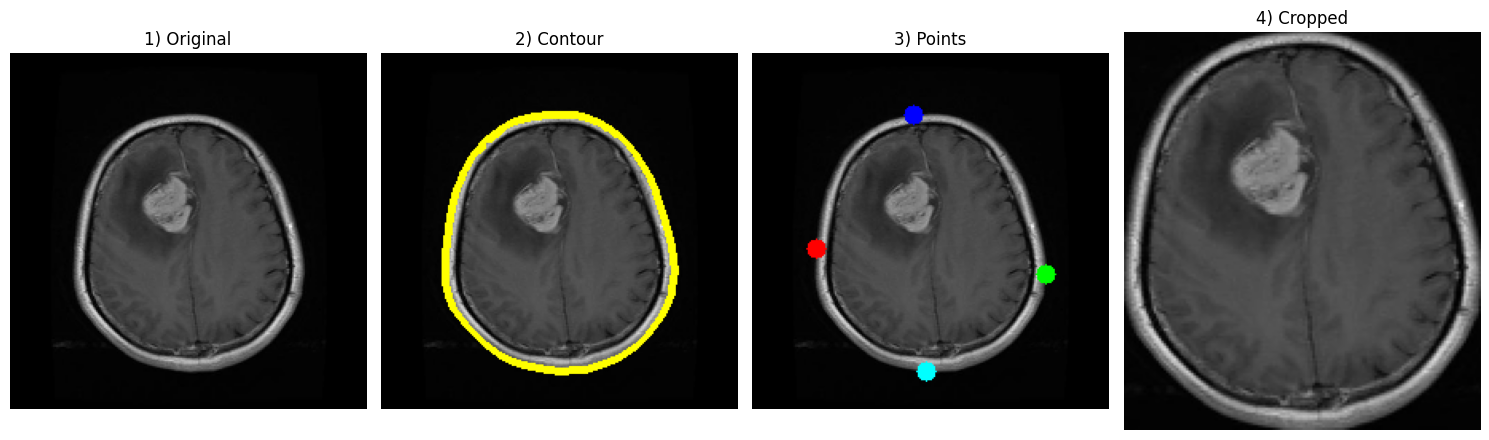

In [13]:
img_bgr = cv2.imread(str(CROP_DEMO_PATH))
if img_bgr is None:
    raise FileNotFoundError(f"Could not read: {CROP_DEMO_PATH}")

img_bgr = cv2.resize(img_bgr, CROP_DEMO_SIZE, interpolation=cv2.INTER_CUBIC)
cropped, contour, pts = crop_by_largest_contour(img_bgr, thresh_val=45, add_pixels=0)

demo_contour = img_bgr.copy()
demo_points = img_bgr.copy()

if contour is not None:
    demo_contour = cv2.drawContours(demo_contour, [contour], -1, (0, 255, 255), 3)
    (pL, pR, pT, pB) = pts
    for pt, color in [(pL, (0, 0, 255)), (pR, (0, 255, 0)), (pT, (255, 0, 0)), (pB, (255, 255, 0))]:
        demo_points = cv2.circle(demo_points, pt, 6, color, -1)

to_rgb = lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1); plt.imshow(to_rgb(img_bgr));       plt.title("1) Original"); plt.axis("off")
plt.subplot(1, 4, 2); plt.imshow(to_rgb(demo_contour));  plt.title("2) Contour");  plt.axis("off")
plt.subplot(1, 4, 3); plt.imshow(to_rgb(demo_points));   plt.title("3) Points");   plt.axis("off")
plt.subplot(1, 4, 4); plt.imshow(to_rgb(cropped));       plt.title("4) Cropped");  plt.axis("off")
plt.tight_layout()
plt.show()


## Dataset Audit after Cropping: Class Distribution and Image Resolution Consistency

This block performs a comprehensive audit of the **cropped dataset** before model training.  
All images from the cropped training and test directories are indexed to analyze class distribution, dataset size, and image resolution characteristics.

### Class Distribution Check
The class frequency counts confirm that the cropped dataset contains **7,023 images across four classes**:
- *No tumor*: 2,000 images  
- *Pituitary*: 1,757 images  
- *Meningioma*: 1,645 images  
- *Glioma*: 1,621 images  

The split sizes (**5,712 training images** and **1,311 test images**) match expectations and confirm that cropping did not remove or duplicate samples.  
Although a moderate class imbalance is present, it is consistent across both pipelines and therefore does not bias the Aug vs No-Aug comparison.

### Why Image Resolution Scatter Matters
In addition to class counts, a **scatter plot of image width vs height** is generated for a random subset of cropped images.  
This step serves several important purposes:

- It verifies that the cropping process produces **consistent image resolutions** across the dataset.
- It helps detect **outliers or extreme aspect ratios** that could destabilize CNN training or introduce unintended biases.
- It confirms that resizing to a fixed input size (later in the pipeline) does not mask upstream preprocessing errors.

Ensuring resolution consistency is critical for CNNs, as convolutional layers assume uniform spatial structure across samples.  
By validating both class distribution and image geometry, this audit step ensures that the cropped dataset is structurally sound and ready for fair, stable model training.

Class frequency counts:
Class: notumor, Count: 2000 images
Class: pituitary, Count: 1757 images
Class: meningioma, Count: 1645 images
Class: glioma, Count: 1621 images

Total dataset size is: 7023 images
Number of classes: 4 classes


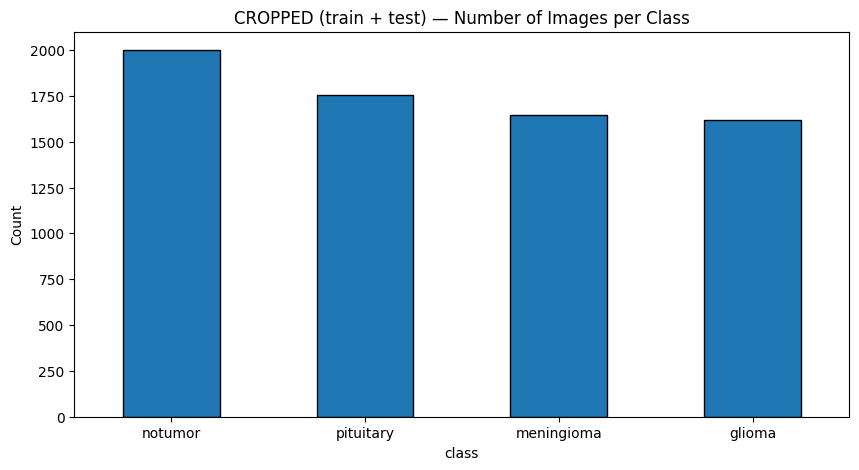

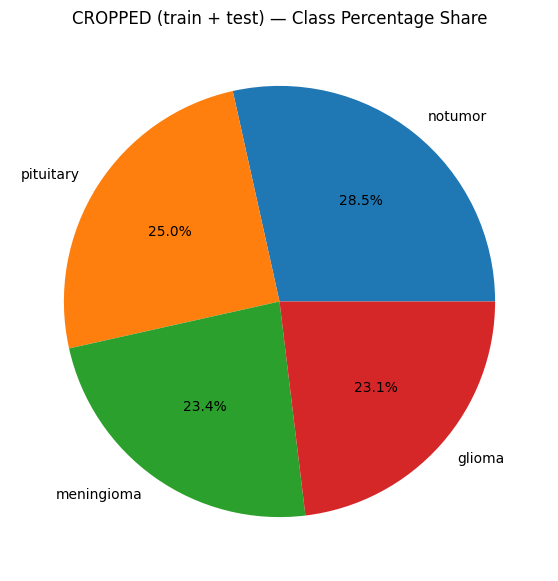

Reading resolutions: 100%|██████████| 800/800 [00:00<00:00, 1411.50it/s]


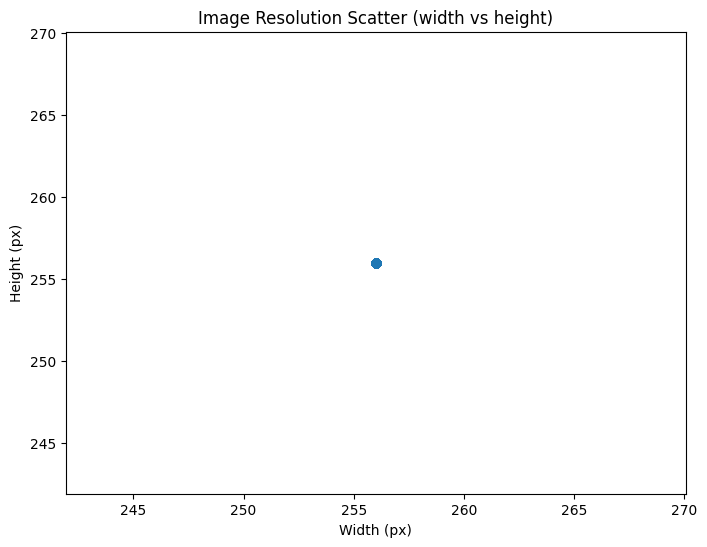


Split sizes:
Cropped train images: 5712
Cropped test images : 1311
Total cropped images: 7023


In [ ]:
import pandas as pd

def index_images_by_class(root_dir: Path, classes: list[str]) -> pd.DataFrame:
    
    rows = []
    for cls in classes:
        cls_dir = root_dir / cls
        if not cls_dir.exists():
            continue
        for p in cls_dir.iterdir():
            if p.suffix.lower() in [".jpg", ".jpeg", ".png"]:
                rows.append({"path": str(p), "class": cls})
    return pd.DataFrame(rows)

def plot_class_stats(df: pd.DataFrame, title: str):
    class_count = df["class"].value_counts()

    print("Class frequency counts:")
    for cls_name, cnt in class_count.items():
        print(f"Class: {cls_name}, Count: {cnt} images")

    print(f"\nTotal dataset size is: {len(df)} images")
    print(f"Number of classes: {df['class'].nunique()} classes")

    # Bar chart
    plt.figure(figsize=(10, 5))
    class_count.plot(kind="bar", edgecolor="black")
    plt.title(f"{title} — Number of Images per Class")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

    # Pie chart
    plt.figure(figsize=(7, 7))
    class_count.plot(kind="pie", autopct="%1.1f%%")
    plt.title(f"{title} — Class Percentage Share")
    plt.ylabel("")
    plt.show()

def plot_image_size_scatter(df: pd.DataFrame, max_samples: int = 800):
    """Scatter: width vs height to detect extreme resolutions."""
    if df.empty:
        print("No images found for size scatter.")
        return

    sample_df = df.sample(min(len(df), max_samples), random_state=42).reset_index(drop=True)

    widths, heights = [], []
    for p in tqdm(sample_df["path"], desc="Reading resolutions"):
        img = cv2.imread(p)
        if img is None:
            continue
        h, w = img.shape[:2]
        widths.append(w)
        heights.append(h)

    plt.figure(figsize=(8, 6))
    plt.scatter(widths, heights)
    plt.title("Image Resolution Scatter (width vs height)")
    plt.xlabel("Width (px)")
    plt.ylabel("Height (px)")
    plt.show()

# Build index from cropped TRAIN + TEST (total distribution)
df_train_crop = index_images_by_class(CROPPED_TRAIN_DIR, CLASSES)
df_test_crop  = index_images_by_class(CROPPED_TEST_DIR, CLASSES)

df_train_crop["split"] = "train"
df_test_crop["split"]  = "test"
df_all = pd.concat([df_train_crop, df_test_crop], ignore_index=True)

# Show distributions
plot_class_stats(df_all, "CROPPED (train + test)")
plot_image_size_scatter(df_all, max_samples=800)

print("\nSplit sizes:")
print("Cropped train images:", len(df_train_crop))
print("Cropped test images :", len(df_test_crop))
print("Total cropped images:", len(df_all))

## Dataset Loading for Baseline Pipeline: True-Color MRI Representation (No Augmentation)

This block loads the cropped MRI images into NumPy arrays for the **no-augmentation (baseline) pipeline**.  
Unlike the augmentation pipeline, images are loaded in their **original color representation** (BGR as read by OpenCV), without grayscale conversion, pseudo-color mapping, or data augmentation.

Each image undergoes the following steps:
- Loaded as a three-channel color image (`cv2.IMREAD_COLOR`).
- Resized to a fixed resolution of **200 × 200 pixels** to match CNN input requirements.
- Normalized to the range **[0, 1]** to stabilize gradient-based optimization.

This design choice serves two purposes:
1. It provides a **clean baseline representation** of the data without additional transformations.
2. It isolates the effect of **data augmentation** in the comparative experiment, since all other components (cropping, architecture, optimizer, and training strategy) remain identical.

From a CNN perspective, using a consistent three-channel input ensures compatibility with the ResNet-50 architecture, while avoiding artificial color transformations that could introduce unintended biases.  
The resulting tensors confirm correct dataset construction and prepare the data for fair baseline training and evaluation.

In [ ]:
import numpy as np
import cv2
from tqdm import tqdm
from pathlib import Path

def load_images_rgb(root_dir: Path, classes: list[str], image_size=(200, 200)):
    
    X, y = [], []
    for label_idx, cls in enumerate(classes):
        cls_dir = root_dir / cls
        if not cls_dir.exists():
            raise FileNotFoundError(f"Missing folder: {cls_dir}")

        file_list = [p for p in cls_dir.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
        for p in tqdm(file_list, desc=f"Loading {cls}", leave=False):
            img_bgr = cv2.imread(str(p), cv2.IMREAD_COLOR)  # (H,W,3) BGR
            if img_bgr is None:
                continue

            img_bgr = cv2.resize(img_bgr, image_size)
            X.append(img_bgr)
            y.append(label_idx)

    X = np.array(X, dtype=np.float32) / 255.0
    y = np.array(y, dtype=np.int32)
    return X, y

X_train_all, y_train_all = load_images_rgb(CROPPED_TRAIN_DIR, CLASSES, image_size=FINAL_IMG_SIZE)
X_test, y_test = load_images_rgb(CROPPED_TEST_DIR, CLASSES, image_size=FINAL_IMG_SIZE)

print("Train:", X_train_all.shape, y_train_all.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (5712, 200, 200, 3) (5712,)
Test : (1311, 200, 200, 3) (1311,)


## Dataset Loading for Baseline Pipeline: True-Color MRI Representation (No Augmentation)

This block loads the cropped MRI images into NumPy arrays for the **no-augmentation (baseline) pipeline**.  
Images are read in their original three-channel format (`cv2.IMREAD_COLOR`), resized to a fixed input size, and normalized to the range **[0, 1]**.

After loading, the resulting dataset tensors confirm correct construction:
- Training set: **(5712, 200, 200, 3)** with labels **(5712,)**
- Test set: **(1311, 200, 200, 3)** with labels **(1311,)**

These shapes verify that each image is represented as a **200×200×3** input suitable for ResNet-50, and that one integer label is assigned per image for multi-class classification.  
This baseline representation intentionally avoids augmentation and additional color transformations, providing a clean reference point for comparison against the augmentation-based pipeline.

## Qualitative Data Check: Preview of Baseline Training Images (No Augmentation)

This block provides a quick visual inspection of a small subset of training images used in the **no-augmentation baseline pipeline**.  
Nine randomly selected images are displayed after loading, resizing, and normalization to verify that the data representation matches expectations.

The images are converted from OpenCV’s BGR format to RGB for correct visualization.  
This step confirms that:
- Images are loaded correctly and retain their original visual structure.
- No unintended transformations or artifacts were introduced during preprocessing.
- Labels (when shown) are correctly aligned with the displayed images.

This qualitative check complements earlier dataset audits and ensures that the baseline pipeline uses clean, unaltered inputs before CNN training begins.

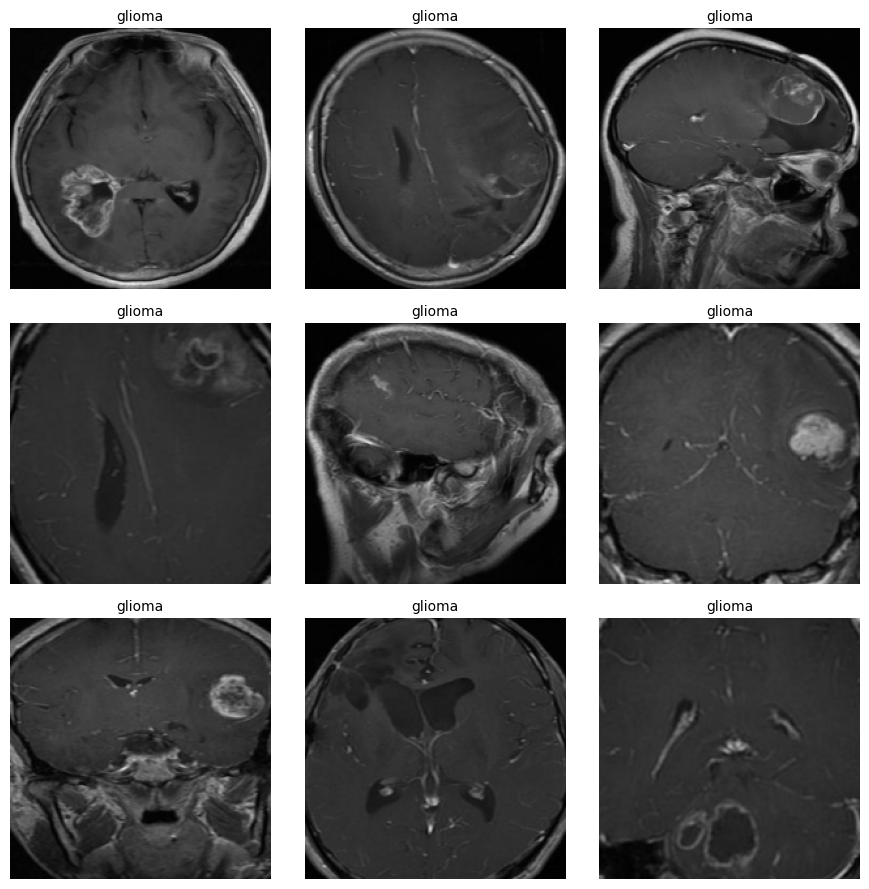

In [ ]:
plt.figure(figsize=(9, 9))

for i in range(9):
    plt.subplot(3, 3, i + 1)

    # X_train_all is float32 in [0,1], stored as BGR (OpenCV)
    img_bgr = (X_train_all[i] * 255).astype(np.uint8)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis("off")

    if "y_train_all" in globals():
        plt.title(CLASSES[int(y_train_all[i])], fontsize=10)

plt.tight_layout()
plt.show()

## Dataset Preparation for CNN Training: Shuffling, One-Hot Encoding, and Train–Validation Split

This block prepares the baseline dataset for convolutional neural network training by applying shuffling, label encoding, and data splitting.  
The training data is first **randomly shuffled** to remove any ordering bias introduced by directory-based loading.

Shuffling is essential for CNN optimization because training is performed using mini-batch gradient descent.  
Randomized sample order ensures that each batch contains a diverse mixture of classes, resulting in more stable gradient updates and improved convergence.

Class labels are then converted into **one-hot encoded vectors**, which are required when training a CNN with a **softmax output layer** and **categorical cross-entropy loss**.  
This encoding represents each class as a probability distribution over the four tumor categories.

Finally, the shuffled training data is split into **training** and **validation** subsets using an 80/20 split:
- Training set: **4,569 images**
- Validation set: **1,143 images**
- Test set: **1,311 images**

All input tensors have shape **(200, 200, 3)**, confirming compatibility with the ResNet-50 architecture.  
This preparation step ensures that the baseline pipeline is structurally identical to the augmentation pipeline, differing only in the absence of data augmentation.

In [17]:
X_train_all, y_train_all = shuffle(X_train_all, y_train_all, random_state=21)

y_train_all_oh = tf.keras.utils.to_categorical(y_train_all, num_classes=NUM_CLASSES)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all_oh, test_size=0.2, random_state=17
)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test_oh.shape)

Train: (4569, 200, 200, 3) (4569, 4)
Val  : (1143, 200, 200, 3) (1143, 4)
Test : (1311, 200, 200, 3) (1311, 4)


## Class Distribution Verification after Train–Validation Split

This block explicitly verifies the class distribution in the training, validation, and test sets after shuffling and splitting.  
For one-hot encoded labels, class counts are obtained by summing across the class dimension.

The resulting distributions are:
- **Training set:** `[1063, 1090, 1260, 1156]`
- **Validation set:** `[258, 249, 335, 301]`
- **Test set:** `[300, 306, 405, 300]`

These counts confirm that all four classes are consistently represented across all splits and that the original class proportions are largely preserved.  
From a CNN training perspective, this is important because severe class imbalance can bias gradient updates and distort evaluation metrics.

By explicitly checking class counts, this step ensures that the baseline pipeline does not introduce unintended distribution shifts and remains directly comparable to the augmentation-based pipeline.

In [ ]:
def class_counts(one_hot):
    return np.sum(one_hot, axis=0).astype(int)

print("Training set class counts:", class_counts(y_train))
print("Validation set class counts:", class_counts(y_val))
print("Testing set class counts   :", class_counts(y_test_oh))

Training set class counts: [1063 1090 1260 1156]
Validation set class counts: [258 249 335 301]
Testing set class counts   : [300 306 405 300]


## Model Architecture and Training Configuration (ResNet-50 Backbone)

This block defines the convolutional neural network architecture, training objective, and optimization strategy used in the **no-augmentation baseline pipeline**.

### ResNet-50 Backbone (Transfer Learning)
A pretrained **ResNet-50** model is used as the convolutional feature extractor.  
The network is initialized with **ImageNet weights** and configured with `include_top=False`, which removes the original ImageNet classifier and retains only the convolutional layers responsible for hierarchical feature extraction.

ResNet-50 employs **residual (skip) connections**, which allow gradients to flow more effectively through deep networks and mitigate the vanishing-gradient problem.  
These connections enable the model to learn residual feature mappings, making it possible to train very deep architectures reliably.

All layers of the ResNet backbone are set to **trainable**, enabling full fine-tuning.  
This allows the pretrained filters to adapt from natural images to the texture and intensity characteristics of MRI data.

### Classification Head
The convolutional output of ResNet-50 is transformed using:
- **Global Average Pooling**, which converts spatial feature maps into a compact feature vector while reducing parameter count and overfitting risk.
- **Dropout (0.4)**, which randomly deactivates neurons during training to improve generalization.
- A **Dense softmax layer** with four output neurons, producing class probabilities for the tumor categories.

### Model Compilation
The model is compiled using:
- **Adam optimizer** with a learning rate of `1e-4`, suitable for stable fine-tuning of pretrained networks.
- **Categorical cross-entropy loss**, which is appropriate for multi-class classification with one-hot encoded labels.
- **Accuracy** as a monitoring metric during training.

### Training Control via Callbacks
To ensure stable and efficient training, three callbacks are used:
- **EarlyStopping** monitors validation loss and halts training if no improvement is observed for 40 epochs, while restoring the best-performing weights.
- **ModelCheckpoint** saves the model state corresponding to the lowest validation loss, ensuring the best generalizing model is preserved.
- **ReduceLROnPlateau** automatically lowers the learning rate when validation performance plateaus, enabling finer convergence.

Together, these components define a robust, fully fine-tuned CNN architecture that balances representational power with controlled generalization for brain tumor classification.

In [19]:
base = ResNet50(
    include_top=False,
    input_shape=FINAL_IMG_SIZE + (3,),
    weights="imagenet"
)

for layer in base.layers:
    layer.trainable = True

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.4)(x)
out = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base.input, outputs=out)
model.summary()

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=40, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5),
]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Model Training Procedure (Baseline Pipeline)

This block initiates supervised training of the ResNet-50–based classification model using the **no-augmentation baseline dataset**.  
The model is trained for up to **65 epochs**, with performance monitored on a held-out validation set at the end of each epoch.

Training is performed using mini-batch gradient descent with a batch size of **28**, which balances computational efficiency and gradient stability.  
At each iteration, model weights are updated to minimize the categorical cross-entropy loss between predicted class probabilities and the true one-hot encoded labels.

Validation data is explicitly provided to track generalization performance and to guide callback behavior.  
Early stopping, learning-rate scheduling, and model checkpointing collectively ensure that training does not overfit and that the best-performing model parameters are retained.

This training configuration mirrors the augmentation pipeline exactly, allowing differences in performance to be attributed solely to the presence or absence of data augmentation.

In [20]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8023 - loss: 0.5220

164/164 ━━━━━━━━━━━━━━━━━━━━ 1014s 6s/step - accuracy: 0.8938 - loss: 0.2802 - val_accuracy: 0.2178 - val_loss: 5.2657 - learning_rate: 1.0000e-04
Epoch 2/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 958s 6s/step - accuracy: 0.9753 - loss: 0.0803 - val_accuracy: 0.2178 - val_loss: 5.6052 - learning_rate: 1.0000e-04
Epoch 3/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9902 - loss: 0.0318

164/164 ━━━━━━━━━━━━━━━━━━━━ 915s 6s/step - accuracy: 0.9895 - loss: 0.0324 - val_accuracy: 0.2161 - val_loss: 4.6995 - learning_rate: 1.0000e-04
Epoch 4/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 862s 5s/step - accuracy: 0.9899 - loss: 0.0318 - val_accuracy: 0.2520 - val_loss: 4.9776 - learning_rate: 1.0000e-04
Epoch 5/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9928 - loss: 0.0293

164/164 ━━━━━━━━━━━━━━━━━━━━ 864s 5s/step - accuracy: 0.9912 - loss: 0.0322 - val_accuracy: 0.7393 - val_loss: 0.7193 - learning_rate: 1.0000e-04
Epoch 6/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 835s 5s/step - accuracy: 0.9919 - loss: 0.0283 - val_accuracy: 0.7463 - val_loss: 0.7551 - learning_rate: 1.0000e-04
Epoch 7/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9884 - loss: 0.0422

164/164 ━━━━━━━━━━━━━━━━━━━━ 824s 5s/step - accuracy: 0.9912 - loss: 0.0296 - val_accuracy: 0.8688 - val_loss: 0.3806 - learning_rate: 1.0000e-04
Epoch 8/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9975 - loss: 0.0149

164/164 ━━━━━━━━━━━━━━━━━━━━ 811s 5s/step - accuracy: 0.9978 - loss: 0.0091 - val_accuracy: 0.9641 - val_loss: 0.1050 - learning_rate: 1.0000e-04
Epoch 9/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 817s 5s/step - accuracy: 0.9956 - loss: 0.0112 - val_accuracy: 0.9449 - val_loss: 0.1873 - learning_rate: 1.0000e-04
Epoch 10/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 875s 5s/step - accuracy: 0.9853 - loss: 0.0495 - val_accuracy: 0.9545 - val_loss: 0.1363 - learning_rate: 1.0000e-04
Epoch 11/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9959 - loss: 0.0147

164/164 ━━━━━━━━━━━━━━━━━━━━ 897s 5s/step - accuracy: 0.9958 - loss: 0.0172 - val_accuracy: 0.9720 - val_loss: 0.0784 - learning_rate: 1.0000e-04
Epoch 12/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 909s 6s/step - accuracy: 0.9980 - loss: 0.0085 - val_accuracy: 0.9738 - val_loss: 0.0831 - learning_rate: 1.0000e-04
Epoch 13/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 942s 6s/step - accuracy: 0.9982 - loss: 0.0072 - val_accuracy: 0.9764 - val_loss: 0.0897 - learning_rate: 1.0000e-04
Epoch 14/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 933s 6s/step - accuracy: 0.9978 - loss: 0.0057 - val_accuracy: 0.9720 - val_loss: 0.1164 - learning_rate: 1.0000e-04
Epoch 15/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 884s 5s/step - accuracy: 0.9947 - loss: 0.0158 - val_accuracy: 0.9606 - val_loss: 0.1627 - learning_rate: 1.0000e-04
Epoch 16/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 915s 6s/step - accuracy: 0.9836 - loss: 0.0693 - val_accuracy: 0.9685 - val_loss: 0.1175 - learning_rate: 1.0000e-04
Epoch 17/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 864s 5s/step - accuracy

164/164 ━━━━━━━━━━━━━━━━━━━━ 836s 5s/step - accuracy: 1.0000 - loss: 4.2210e-04 - val_accuracy: 0.9851 - val_loss: 0.0770 - learning_rate: 5.0000e-05
Epoch 32/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 817s 5s/step - accuracy: 1.0000 - loss: 2.4943e-04 - val_accuracy: 0.9851 - val_loss: 0.0772 - learning_rate: 5.0000e-05
Epoch 33/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 854s 5s/step - accuracy: 0.9998 - loss: 3.9553e-04 - val_accuracy: 0.9843 - val_loss: 0.0775 - learning_rate: 5.0000e-05
Epoch 34/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 1.0000 - loss: 1.5821e-04

164/164 ━━━━━━━━━━━━━━━━━━━━ 838s 5s/step - accuracy: 1.0000 - loss: 2.2252e-04 - val_accuracy: 0.9843 - val_loss: 0.0767 - learning_rate: 5.0000e-05
Epoch 35/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 847s 5s/step - accuracy: 1.0000 - loss: 4.2750e-04 - val_accuracy: 0.9808 - val_loss: 0.0835 - learning_rate: 5.0000e-05
Epoch 36/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 843s 5s/step - accuracy: 1.0000 - loss: 1.4237e-04 - val_accuracy: 0.9799 - val_loss: 0.0828 - learning_rate: 5.0000e-05
Epoch 37/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 851s 5s/step - accuracy: 1.0000 - loss: 8.1236e-05 - val_accuracy: 0.9825 - val_loss: 0.0826 - learning_rate: 5.0000e-05
Epoch 38/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 838s 5s/step - accuracy: 1.0000 - loss: 2.2940e-04 - val_accuracy: 0.9834 - val_loss: 0.0853 - learning_rate: 5.0000e-05
Epoch 39/65
164/164 ━━━━━━━━━━━━━━━━━━━━ 833s 5s/step - accuracy: 0.9996 - loss: 7.4814e-04 - val_accuracy: 0.9825 - val_loss: 0.0955 - learning_rate: 5.0000e-05
Epoch 40/65
164/164 ━━━━━━━━━━━━━━━━━━━━

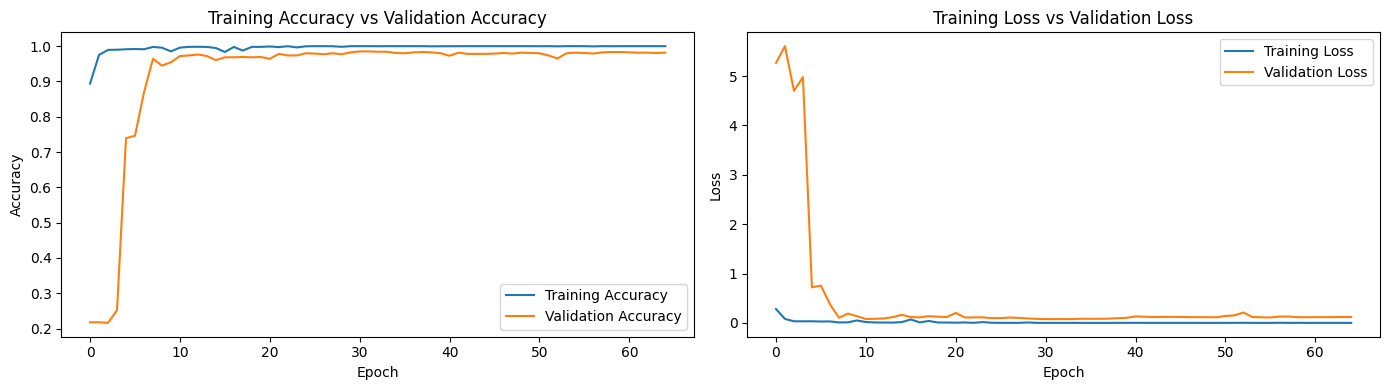

In [ ]:
acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

plt.figure(figsize=(14, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Training Accuracy vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Loss 
plt.subplot(1, 2, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

## Interpretation of Learning Curves (No-Augmentation Baseline)

The learning curves show rapid convergence of the model during the initial training phase, followed by stable performance across later epochs.

### Accuracy Behavior
Training accuracy increases sharply within the first few epochs and quickly approaches values close to **100%**, indicating that the model is able to fit the training data very effectively.  
Validation accuracy follows a similar trend after a short delay, stabilizing at approximately **98–99%**. The close alignment between training and validation accuracy suggests strong generalization and no severe overfitting.

The small, consistent gap between training and validation accuracy is expected in deep CNNs and reflects the model’s capacity rather than instability.

### Loss Behavior
Training loss drops rapidly and approaches near-zero values early in training, confirming successful optimization of the categorical cross-entropy objective.  
Validation loss initially starts high and exhibits sharp fluctuations during the first few epochs, which is typical when fine-tuning deep pretrained models.

After the early phase, validation loss stabilizes at a low level with minor oscillations. These small fluctuations indicate sensitivity to individual validation samples rather than divergence or overfitting.

### Overall Assessment
- The model converges quickly and remains stable throughout training.
- There is no evidence of exploding loss or validation collapse.
- Regularization strategies (dropout, learning-rate scheduling, early stopping) effectively control overfitting despite full fine-tuning of ResNet-50.

Overall, the curves indicate a **well-optimized and well-generalizing baseline model**, providing a reliable reference point for comparison with the augmentation-based pipeline.

## Final and Best Validation Performance (No-Augmentation Baseline)

At the final training epoch, the model achieves **perfect training accuracy (1.0000)** with a **near-zero training loss (0.0001)**, indicating complete fitting of the training data.  
This behavior is expected for a fully fine-tuned deep CNN without data augmentation and confirms the model’s high representational capacity.

On the validation set, the final epoch yields a **validation accuracy of 98.16%** and a **validation loss of 0.1197**.  
Importantly, the *best* validation performance is observed earlier during training, with:
- **Best validation accuracy:** **98.51%**
- **Best validation loss:** **0.0767**

This difference highlights that validation loss and accuracy do not necessarily improve monotonically.  
While training continues, small confidence shifts in predicted probabilities can increase loss even when classification accuracy remains high.

The use of **ModelCheckpoint** ensures that the model state corresponding to the lowest validation loss is preserved, preventing degradation due to late-stage overfitting.  
Overall, these results establish a strong and stable baseline against which the augmentation-based pipeline can be fairly compared.

In [ ]:
acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

# Print final (last epoch) metrics 
if len(acc) and len(val_acc) and len(loss) and len(val_loss):
    print(f"Final Train Accuracy : {acc[-1]:.4f}")
    print(f"Final Val Accuracy   : {val_acc[-1]:.4f}")
    print(f"Final Train Loss     : {loss[-1]:.4f}")
    print(f"Final Val Loss       : {val_loss[-1]:.4f}")
else:
    print("History keys available:", list(history.history.keys()))


print(f"Best Val Accuracy : {max(val_acc):.4f}")
print(f"Best Val Loss     : {min(val_loss):.4f}")


Final Train Accuracy : 1.0000
Final Val Accuracy   : 0.9816
Final Train Loss     : 0.0001
Final Val Loss       : 0.1197
Best Val Accuracy : 0.9851
Best Val Loss     : 0.0767


## Label Preparation for Evaluation and Interpretability

This block standardizes the test labels to ensure compatibility across evaluation, reporting, and interpretability steps such as Grad-CAM.

Depending on the earlier preprocessing pipeline, test labels may exist in one of two formats:
- **One-hot encoded vectors** (e.g., `[0, 0, 1, 0]`)
- **Integer class indices** (e.g., `2`)

To handle both cases robustly, the labels are converted into a unified **integer-based representation**.  
If the labels are one-hot encoded, the class index is recovered using `argmax`. If they are already integers, they are retained as-is.

The resulting label vector has shape **(1311,)** with unique values **[0, 1, 2, 3]**, confirming:
- Correct alignment with the four defined class names.
- One label per test image.
- Compatibility with downstream tasks such as confusion matrix computation, classification reports, and per-image Grad-CAM visualization.

This explicit label normalization step prevents subtle mismatches between prediction outputs and ground-truth labels, ensuring reliable and interpretable evaluation results.

In [24]:
import numpy as np

CLASS_NAMES = ["glioma", "meningioma", "no_tumor", "pituitary"]

# If y_test is one-hot encoded -> convert to integer labels
# If y_test is already integer labels -> keep as-is
if "y_test" not in globals():
    raise NameError("y_test is not defined. Make sure you loaded your test labels first.")

if isinstance(y_test, np.ndarray) and y_test.ndim == 2:
    y_test_int = np.argmax(y_test, axis=1)
else:
    y_test_int = np.asarray(y_test).astype(int)

print("y_test_int shape:", y_test_int.shape)
print("Unique test labels:", np.unique(y_test_int))

y_test_int shape: (1311,)
Unique test labels: [0 1 2 3]


## Model Evaluation on the Test Set

This block evaluates the trained CNN on the **held-out test set**, which has not been used during training or validation.  
The purpose of this step is to obtain an unbiased estimate of the model’s generalization performance.

Because the training pipeline uses **categorical cross-entropy loss**, the model expects labels in **one-hot encoded format**.  
However, depending on earlier preprocessing steps, test labels may exist either as:
- One-hot encoded vectors, or
- Integer class indices.

To ensure compatibility and prevent silent evaluation errors, the code explicitly checks the label format:
- If labels are already one-hot encoded, they are used directly.
- If labels are integer-encoded, they are converted to one-hot vectors.

The model is then evaluated using the standardized one-hot test labels, producing the final **test loss** and **test accuracy**.  
These metrics reflect the model’s true predictive performance on unseen data and serve as the primary benchmark for comparison with the augmentation-based pipeline.

In [25]:
import numpy as np


if isinstance(y_test, np.ndarray) and y_test.ndim == 2:
    y_test_onehot = y_test
    y_test_int = np.argmax(y_test, axis=1)
else:
    y_test_int = np.asarray(y_test).astype(int)
    y_test_onehot = tf.keras.utils.to_categorical(y_test_int, num_classes=NUM_CLASSES)


test_loss, test_acc = model.evaluate(X_test, y_test_onehot, verbose=0)

print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

Test Loss     : 0.0469
Test Accuracy : 0.9886


## Saving the Trained Baseline Model

This block saves the trained CNN model, including both its **architecture** and **learned weights**, to disk.  
Persisting the model enables reproducibility, later evaluation, and interpretability analyses such as **Grad-CAM visualization** without retraining.

The model is stored using the HDF5 (`.h5`) format. Although this format is now considered legacy by Keras, it remains widely supported and is fully compatible with:
- `load_model()` for inference and evaluation
- Existing Grad-CAM and visualization utilities
- Cross-environment model reuse

Importantly, the saved model represents the **final trained baseline state** and serves as a fixed reference point for comparison with the augmentation-based pipeline.

In [26]:
MODEL_OUT = "brainmri_preprocessingpnoaug.h5"
model.save(MODEL_OUT)
print("Saved model to:", MODEL_OUT)

Saved model to: brainmri_preprocessingpnoaug.h5


## Model Reloading and Integrity Check

This optional block reloads the saved baseline model from disk to verify that the stored architecture and weights can be restored correctly.  
Successfully reloading the model confirms that the serialization process preserved all necessary information for inference and evaluation.

This integrity check is particularly important because the reloaded model is later reused for:
- Test-set analysis,
- Confusion matrix and classification report generation, and
- Interpretability techniques such as **Grad-CAM**.

By explicitly reloading the model, this step ensures that all downstream analyses operate on the exact saved model state rather than an in-memory training instance, supporting reproducibility and experimental rigor.

In [27]:
from tensorflow.keras.models import load_model

MODEL_IN = "brainmri_preprocessingpnoaug.h5"
model = load_model(MODEL_IN)
print("Reloaded model from:", MODEL_IN)

Reloaded model from: brainmri_preprocessingpnoaug.h5


## Test-Set Performance Analysis: Classification Report

This block evaluates the trained baseline model on the **held-out test set** using detailed classification metrics.  
Predicted class probabilities are first generated by the model and then converted into discrete class labels using `argmax`.

Overall test performance is summarized by a **Sklearn accuracy of 98.86%**, confirming strong generalization to unseen MRI images.

### Per-Class Performance Interpretation
The classification report provides **precision**, **recall**, and **F1-score** for each tumor class:

- **Glioma:** High precision (0.9933) and recall (0.9867) indicate reliable detection with few false positives or false negatives.
- **Meningioma:** Slightly lower recall (0.9771) suggests a small number of misclassifications, but overall performance remains strong.
- **No Tumor:** Perfect recall (1.0000) shows that all healthy cases were correctly identified, which is particularly important in a medical screening context.
- **Pituitary:** Balanced precision and recall (both ≈ 0.987) indicate stable and consistent predictions.

The **macro-averaged** and **weighted** metrics are closely aligned, indicating that performance is consistent across classes despite moderate class imbalance.

### Overall Assessment
These results demonstrate that the no-augmentation baseline model achieves high and well-balanced classification performance across all four classes.  
The strong test-set metrics establish a reliable reference point for assessing the impact of data augmentation and for subsequent interpretability analysis using Grad-CAM.

In [28]:
from sklearn.metrics import classification_report, accuracy_score

y_prob = model.predict(X_test, batch_size=32, verbose=1)
y_pred_int = np.argmax(y_prob, axis=1)

print("Sklearn Accuracy:", accuracy_score(y_test_int, y_pred_int))

print(
    classification_report(
        y_test_int,
        y_pred_int,
        target_names=CLASS_NAMES,
        digits=4
    )
)

41/41 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step
Sklearn Accuracy: 0.988558352402746
              precision    recall  f1-score   support

      glioma     0.9933    0.9867    0.9900       300
  meningioma     0.9836    0.9771    0.9803       306
    no_tumor     0.9902    1.0000    0.9951       405
   pituitary     0.9867    0.9867    0.9867       300

    accuracy                         0.9886      1311
   macro avg     0.9884    0.9876    0.9880      1311
weighted avg     0.9886    0.9886    0.9885      1311



## Confusion Matrix Analysis: Error Structure and Class-Specific Behavior

This block visualizes the model’s classification behavior on the test set using **confusion matrices**, shown both as raw counts and as normalized proportions.

### Raw Confusion Matrix (Counts)
The first confusion matrix displays the **absolute number of predictions** for each true–predicted class combination.  
Diagonal entries represent correct classifications, while off-diagonal entries indicate misclassifications between specific tumor classes.

This view highlights:
- Which classes are most frequently confused with each other.
- The absolute scale of errors relative to class size.
- Whether misclassifications are rare events or systematic patterns.

### Normalized Confusion Matrix
The second confusion matrix is **normalized by the true class**, meaning each row sums to 1.  
This representation shows the **percentage of samples per class** that are predicted correctly or incorrectly.

Normalization is especially important when class sizes differ, as it allows direct comparison of model performance across classes regardless of dataset imbalance.

### Interpretation
The dominance of high values along the diagonal in both matrices confirms strong classification performance across all tumor categories.  
The low magnitude of off-diagonal values indicates that misclassifications are infrequent and not concentrated in a single class pair.

Together, the raw and normalized confusion matrices provide complementary insights:
- The raw matrix shows *how many* mistakes occur.
- The normalized matrix shows *how often* mistakes occur per class.

This analysis supports the quantitative metrics reported earlier and offers a transparent view of the model’s error structure before interpretability analysis using Grad-CAM.

<Figure size 700x600 with 0 Axes>

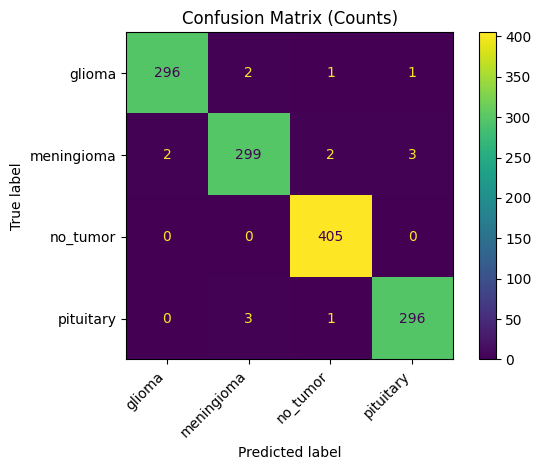

<Figure size 700x600 with 0 Axes>

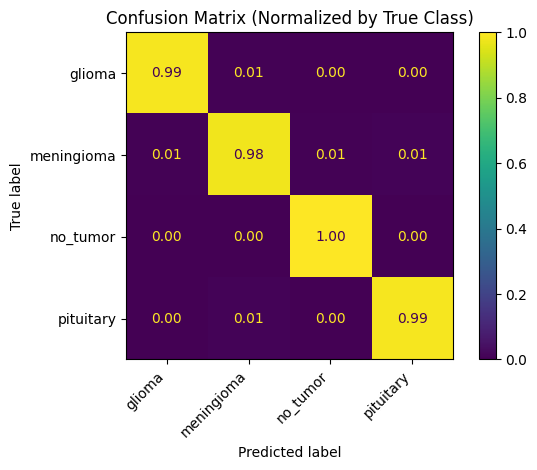

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_int, y_pred_int)

plt.figure(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(values_format="d")  # raw counts
plt.title("Confusion Matrix (Counts)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

cm_norm = confusion_matrix(y_test_int, y_pred_int, normalize="true")

plt.figure(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=CLASS_NAMES)
disp.plot(values_format=".2f")  # normalized
plt.title("Confusion Matrix (Normalized by True Class)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Qualitative Prediction Inspection: Random Test Grid (Predicted vs True)

This block provides a qualitative inspection of model behavior by displaying a random selection of test images with both the **predicted** and **true** class labels.  
While metrics such as accuracy and F1-score summarize performance numerically, this visualization helps verify that predictions “look reasonable” and supports transparent error analysis.

Key aspects of this grid:
- **Random sampling** is used to avoid cherry-picking examples and to reflect typical test-set behavior.
- Images are converted from OpenCV’s **BGR** format to **RGB** so that MRI images appear correctly in matplotlib.
- Each image is annotated with:
  - the predicted class (`Pred:`), and  
  - the ground-truth label (`True:`).

Border colors provide an immediate correctness cue:
- **Dark green border** = correct classification  
- **Orange border** = incorrect classification  

This qualitative check complements the confusion matrix by allowing visual inspection of:
- typical correct predictions,
- the appearance of misclassified samples, and
- whether errors occur in visually ambiguous cases.

These inspected examples also serve as useful candidates for subsequent **Grad-CAM analysis**, where attention maps can help explain why the model predicted a given class.

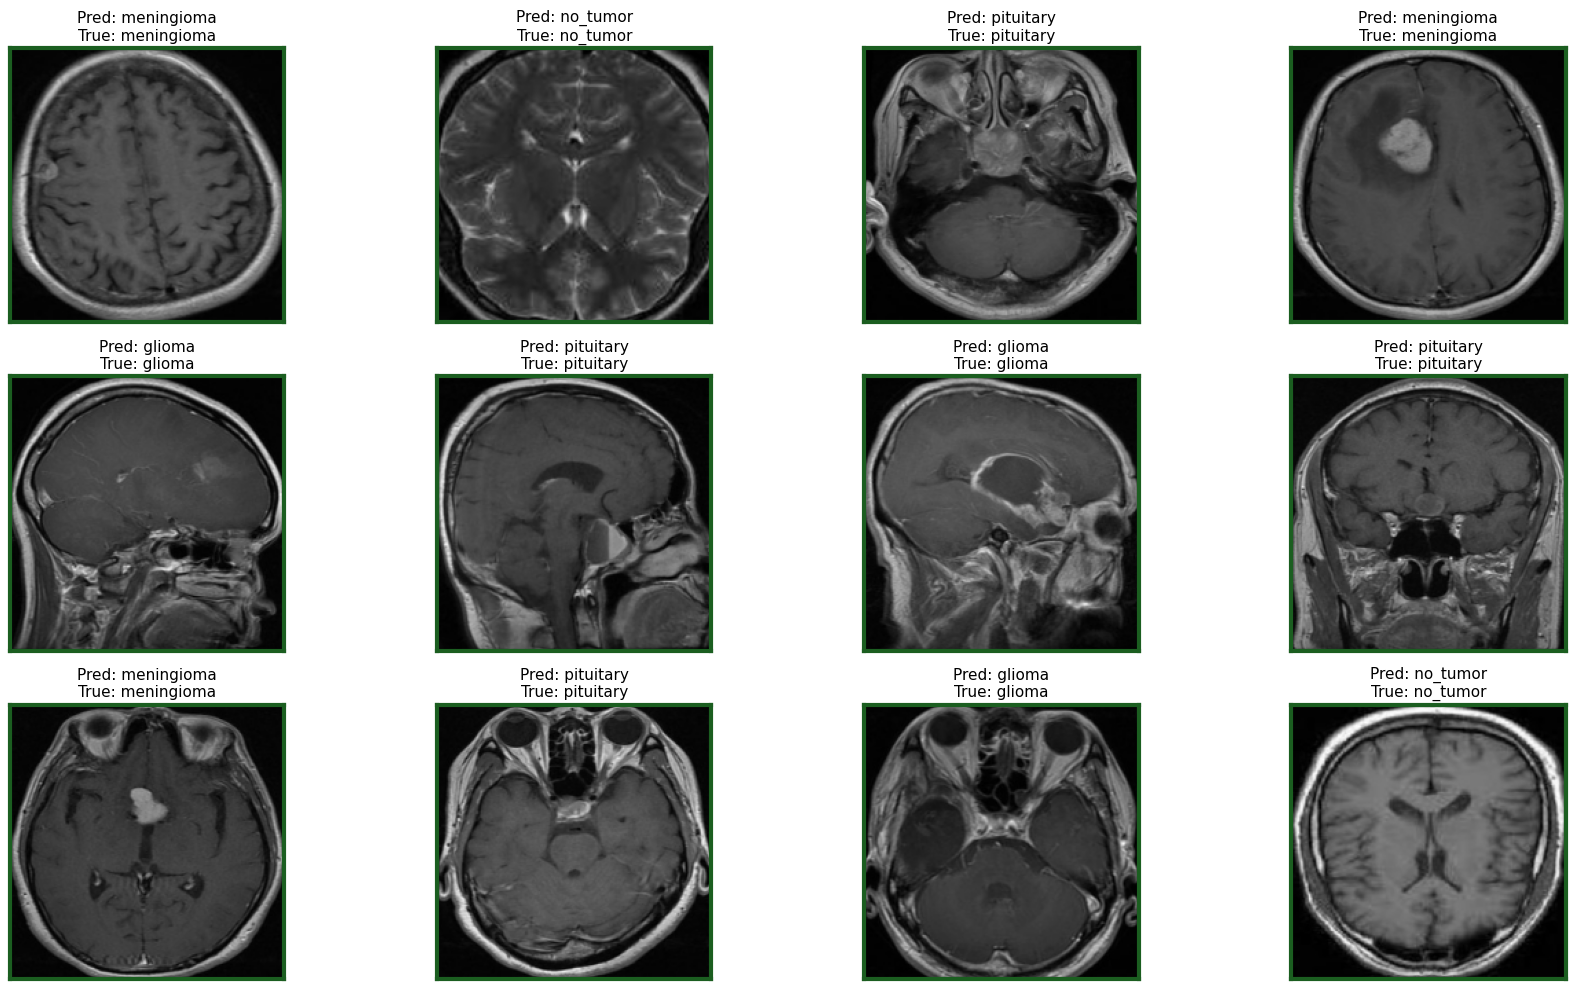

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def to_rgb_uint8(img_float01):
    img_bgr = (img_float01 * 255).astype(np.uint8)
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

N_SHOW = 12
idxs = np.random.choice(X_test.shape[0], size=min(N_SHOW, X_test.shape[0]), replace=False)

fig = plt.figure(figsize=(18, 10))
rows = 3
cols = int(np.ceil(len(idxs) / rows))

for k, idx in enumerate(idxs):
    ax = fig.add_subplot(rows, cols, k + 1, xticks=[], yticks=[])

    img_rgb = to_rgb_uint8(X_test[idx])
    ax.imshow(img_rgb)

    pred_idx = int(y_pred_int[idx])
    true_idx = int(y_test_int[idx])

    title = f"Pred: {CLASS_NAMES[pred_idx]}\nTrue: {CLASS_NAMES[true_idx]}"
    ax.set_title(title, fontsize=11)

    
    is_ok = (pred_idx == true_idx)
    border_color = "#1B5E20" if is_ok else "#F57C00"
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(3)
        spine.set_edgecolor(border_color)

plt.tight_layout()
plt.show()

## Single-Image Inference Check: Per-Class Examples with Probability Outputs

This block performs a transparent, human-readable sanity check by running inference on **one representative test image per class**.  
Instead of only relying on aggregated metrics (accuracy, F1-score, confusion matrix), this step verifies that the model produces sensible predictions on individual samples and returns a valid probability distribution across classes.

### What the code does
For each selected test image:
- The image is loaded and resized to the model’s input size (**200×200**).
- Pixel values are normalized to **[0, 1]** to match training preprocessing.
- The model outputs a **softmax probability vector** over the four classes.
- The predicted label is chosen using `argmax`, and all class probabilities are printed.

### How to interpret the printed probabilities
Softmax values represent the model’s **confidence distribution** across classes for that specific image:
- A probability close to **1.0** for the predicted class indicates a highly confident decision.
- Non-zero probabilities for other classes show which alternatives the model considered most plausible.

In the shown examples, the model assigns very high probability to the correct class (e.g., ≈0.996–0.999+), which is consistent with the strong test-set performance.  
This per-image inspection also helps identify cases where the prediction is correct but the confidence is low (or incorrect but highly confident), which is important for medical interpretability and risk awareness.

These example images can also be reused as inputs for **Grad-CAM visualization**, enabling a direct link between predicted probabilities and spatial explanation maps.

In [34]:
from tensorflow.keras.preprocessing import image as kimage
import numpy as np

def predict_one_image(img_path: str, true_label: str, target_size=(200, 200)):
    img = kimage.load_img(img_path, target_size=target_size)
    x = kimage.img_to_array(img).astype(np.float32) / 255.0
    x = np.expand_dims(x, axis=0)

    probs = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_label = CLASS_NAMES[pred_idx]

    print("\nImage:", img_path)
    print("True Label :", true_label)
    print("Predicted  :", pred_label)
    print("Probabilities:", {CLASS_NAMES[i]: float(probs[i]) for i in range(len(CLASS_NAMES))})

#One test image path per class 
sample_paths = {
    "glioma":      "/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/glioma/Te-gl_0017.jpg",
    "meningioma":  "/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/meningioma/Te-me_0022.jpg",
    "no_tumor":    "/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/notumor/Te-no_0087.jpg",
    "pituitary":   "/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/pituitary/Te-pi_0036.jpg",
}

for true_cls, p in sample_paths.items():
    predict_one_image(p, true_label=true_cls, target_size=(200, 200))



Image: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/glioma/Te-gl_0017.jpg
True Label : glioma
Predicted  : glioma
Probabilities: {'glioma': 0.9960883855819702, 'meningioma': 0.003906769212335348, 'no_tumor': 3.081918521274929e-06, 'pituitary': 1.7896070403367048e-06}

Image: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/meningioma/Te-me_0022.jpg
True Label : meningioma
Predicted  : meningioma
Probabilities: {'glioma': 3.052582178497687e-05, 'meningioma': 0.9999673366546631, 'no_tumor': 1.9783421976171667e-06, 'pituitary': 1.4357244992879714e-07}

Image: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/notumor/Te-no_0087.jpg
True Label : no_tumor
Predicted  : no_tumor
Probabilities: {'glioma': 1.4643919712398201e-06, 'meningioma': 9.638832125347108e-05, 'no_tumor': 0.9998914003372192, 'pituitary': 1.0671784366422798e-05}

Image: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain/pituitary/T